# Electric Vehicle (EV) Charging Infrastructure in the US
## Introduction 

The adoption of electric vehicles across the United States is accelerating, transforming the nation’s transportation landscape. As more drivers consider ditching fossil fuels for electricity, the availability of charging stations becomes pivotal—unlike gas stations, chargers aren’t yet ubiquitous. Charging infrastructure is the foundation of this transition; without a reliable, accessible network, widespread EV use simply stalls.

This notebook analyzes the EV charging infrastructure across U.S. states, combining charger counts, charger types, and geography with indicators of EV ownership. The goal is to surface where access is strong, where gaps persist, and how infrastructure aligns with adoption.

- Coverage: Which states have the highest and lowest concentrations of charging stations?
- Density: How does charging infrastructure density vary by state size (e.g., chargers per 100 square miles)?
- Accessibility: How does the EVs-per-charger ratio differ by state, and what does it suggest about ease of access?
- Technology mix: How are advanced chargers (DC fast chargers) distributed relative to Level 1 and Level 2?
- Alignment with adoption: How does infrastructure (counts, density, DCFC share) align with EV ownership levels?

After completing this analysis, readers will gain a clear picture of the current state of EV charging deployment across the United States. They will see which regions are best suited for owning an electric vehicle, and understand whether it’s feasible to travel long distances across the country without the risk of being stranded with a depleted battery.

---
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/yoav-es/ev_charging_infra_us/MASTER)


## Python libraries
This project will use the following Python libraries throughout this analysis:
- pandas – for data loading, cleaning, and formatting
- numpy – for numerical operations and calculations
- matplotlib & seaborn – for creating visualizations and exploring trends



In [89]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Enable inline plotting
%matplotlib inline

## Data Loading
To start our analysis, we’ll load the dataset into a Pandas DataFrame. This will give us a flexible and powerful structure for examining trends, performing calculations, and preparing visualizations.

In [90]:
def load_data(path):
    """Load the dataset from a CSV file."""
    df = pd.read_csv(path)
    return df

# Load the data
ev_charger_data = load_data('ev_chargers_data.csv')
ev_charger_data.head()
print(f"number of rows {ev_charger_data.shape[0]} ")
print(ev_charger_data.dtypes)
print(ev_charger_data.State.nunique())


number of rows 54 
State                           object
Total Evs                       object
Total Chargers                  object
Ratio: EVs to Charger Ports    float64
Level 1 Chargers                object
Level 2 Chargers                object
DCFC Chargers                   object
Square Mileage of State        float64
Unnamed: 8                     float64
Unnamed: 9                     float64
dtype: object
54


## Data Review

The EV charging dataset contains **54 rows**, each representing a U.S. state, the District of Columbia, or a U.S. territory, with several attributes describing EV charging infrastructure and usage. These attributes enable analysis of the availability, distribution, and accessibility of charging stations across the country.

At the bottom of the CSV file, there are additional rows containing **summary statistics** — *Median*, *Average*, and *Total* — which will be excluded from state‑level analysis but may be useful for high‑level comparisons.

**Key variables:**
- `State` – Name of the U.S. state, the District of Columbia.  
- `Total Evs` – Total number of registered electric vehicles in that state.  
- `Total Chargers` - Total number of registered electric vehicles in that state.  
- `EV-to-Charger Ratio` – Ratio of EVs to available public charging ports (lower ratios indicate better charger availability).  
- `Level 1 Chargers` – Number of public Level 1 charging ports (standard household‑type outlets; slowest charging speed).  
- `Level 2 Chargers` – Number of public Level 2 charging ports (240V; faster than Level 1, common in workplaces and public parking).  
- `DCFC Chargers` – Number of public DC fast charging ports (high‑power chargers capable of rapidly charging EV batteries). Also known as Level 3 Chargers. 
- `Square Mileage` – Total land area of the state or territory in square miles.  

---

## Data Cleaning

A review of the dataset identified several necessary preprocessing steps:

1. **Remove empty columns** – Two columns without titles or data will be dropped.

2. **Filter rows** – The dataset includes 54 entries; after removing *Total*, *Average*, and *Median* rows, 51 remain.

    The extra entry beyond the 50 states is the **District of Columbia**, a federal district that will be retained for analysis but clearly labeled as such.  

3. **Standardize column names** – Convert all headers to lowercase, rename *Chargers, Ratio: EVs to Charger Ports* to a clearer label such as `ev_to_charger_ratio` and rename DCFC chargers to level 3 chargers for better uniformity.   

4. **Correct data types** – Convert numeric columns (`total_evs`, `total_chargers`, `level_1_chargers`, `level_2_chargers`, `dcfc_chargers`) 

    from `object` to `float64` for accurate calculations.  

5. **Remove duplicates** – Ensure each record is unique.

6. **Handle missing values** – Address nulls through imputation or removal, depending on context. One is missing for the ratio column in the total row. Seems like its missing at random (MAR). 

7. **Clean text fields** – Normalize formatting (consistent casing, trim whitespace, fix encoding issues). 

8. **Standardize numerical formats** – Ensure consistent decimal separators and units, remove commas from numbers. 

9. **Validate data integrity** – Confirm that each column’s data type matches its intended use.  

These steps will ensure the dataset is clean, consistent, and ready for accurate analysis.

In [91]:
def clean_data(df):
    """Clean and format the DataFrame."""
    print(df.isna().sum())

    # Drop empty columns
    df = df.dropna(axis=1, how='all')

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    # Standardize column names
    df.columns = df.columns.str.lower().str.strip()

    # Rename ratio column 
    df.rename(columns={"ratio: evs to charger ports": "ev_charger_ratio"}, inplace=True)

    # Rename dcfc column 
    df.rename(columns={"dcfc chargers": "level 3 chargers"}, inplace=True)
    
    # rename square are
    df.rename(columns={"square mileage of state": "area size"}, inplace=True)

    # Remove commas and convert numeric columns to float
    num_cols = ["total evs", "total chargers", "level 1 chargers", "level 2 chargers", "level 3 chargers"]
    df[num_cols] = df[num_cols].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')

    # Recalculate ratio
    df["ev_charger_ratio"] = df["total evs"] / df["total chargers"]

    # Create summary tag 
    df['is_summary'] = df['state'].str.lower().isin(['total', 'average', 'median'])

    df_cleaned = df[~df['is_summary']]

    # Optional: validate dtypes
    assert 'object' not in df.dtypes[1:], "Non-numeric dtype found in numeric columns"
    assert not df.isna().any().any(), "DataFrame contains missing values"
    
    return df_cleaned

# Clean the data
ev_charger_data = clean_data(ev_charger_data)
print('Data cleaned successfully!')


State                           0
Total Evs                       0
Total Chargers                  0
Ratio: EVs to Charger Ports     1
Level 1 Chargers                0
Level 2 Chargers                0
DCFC Chargers                   0
Square Mileage of State         0
Unnamed: 8                     54
Unnamed: 9                     54
dtype: int64
Data cleaned successfully!


C:\Users\Yoav\AppData\Local\Temp\ipykernel_17504\3668326619.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)
C:\Users\Yoav\AppData\Local\Temp\ipykernel_17504\3668326619.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"ratio: evs to charger ports": "ev_charger_ratio"}, inplace=True)
C:\Users\Yoav\AppData\Local\Temp\ipykernel_17504\3668326619.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

## Exploratory Data Analysis (EDA)

With the summary rows excluded, we now explore the cleaned dataset to uncover patterns in EV adoption and charging infrastructure across states.

---

### Total EVs
- There's a **huge disparity** in EV ownership across states.
- The **average** number of EVs is approximately **42,099**, while the **median** is **14,684**, indicating a skewed distribution.
- The state with the **most EVs**  is california with **930,811**, while North dakota has the **least** with **656** units.
- The **standard deviation** is **128,487.10**, reinforcing the idea of uneven distribution and a few states dominating EV adoption.

---

### Total Chargers
- The number of chargers also varies widely across states.
- The **average** is around **2,143**, and the **median** is **937**, again showing a skewed distribution.
- The state with the **most chargers** is california with **34,185**, while alaska has the **least** with just **81**.
- The **standard deviation** is **4,766.79**, suggesting significant variation in infrastructure investment.

---

### Level 1 Chargers
- These are the **least common** type of charger.
- The **average** is about **25.59**, and the **median** is **7.0**, with many states having very few or none.
- The state with the **most Level 1 chargers** is california with **280**, while alaska doesnt have any.
- This suggests Level 1 chargers may not be prioritized, likely due to their slower charging speed.

---

### Level 2 Chargers
- These are **more widely adopted** than Level 1 chargers.
- The **average** is approximately **1,726.86**, while the **median** is **685.0**.
- The state with the **most Level 2 chargers** is california with **27,762**, while alaska has just **73**.
- This wide range reflects differing levels of infrastructure development and EV support.

---

### Level 3 Chargers (DC Fast Chargers)
- These fast chargers are **critical for long-distance travel and quick top-ups**.
- The **average** is around **390.82**, and the **median** is **195.0**.
- The state with the **most Level 3 chargers** is california with **6,143**, while alaska has only **8**.
- This highlights a potential gap in high-speed charging access, which could affect EV usability in certain regions.
---



In [92]:
# Count variables analysis function
def explore_count_data(df, column_name):
    """Perform exploratory data analysis on a specified column in the DataFrame."""
    column = df[column_name]
    
    mean = column.mean()
    median = column.median()
    max_value = column.max()
    min_value = column.min()
    sd_var = column.std()
    variance = column.var()

    max_state = df.loc[column.idxmax(), 'state']
    min_state = df.loc[column.idxmin(), 'state']

    return {
        column_name: {
            "average": mean,
            "median": median,
            "maximum value": max_value,
            "maximum state": max_state,
            "minimum value": min_value,
            "minimum state": min_state,
            "standard deviation": sd_var,
            "variance": variance
        }
    }


# Analyze coulmns
cols_to_analyze =["total evs",
"total chargers",
"level 1 chargers",
"level 2 chargers",
"level 3 chargers"]
for col in cols_to_analyze:
    print(explore_count_data(ev_charger_data, col))





{'total evs': {'average': np.float64(42099.41176470588), 'median': np.float64(14684.0), 'maximum value': np.int64(930811), 'maximum state': 'California', 'minimum value': np.int64(656), 'minimum state': 'North Dakota', 'standard deviation': np.float64(129765.61234952448), 'variance': np.float64(16839114148.44706)}}
{'total chargers': {'average': np.float64(2143.274509803922), 'median': np.float64(937.0), 'maximum value': np.int64(34185), 'maximum state': 'California', 'minimum value': np.int64(81), 'minimum state': 'Alaska', 'standard deviation': np.float64(4814.219384608189), 'variance': np.float64(23176708.283137247)}}
{'level 1 chargers': {'average': np.float64(25.58823529411765), 'median': np.float64(7.0), 'maximum value': np.float64(280.0), 'maximum state': 'California', 'minimum value': np.float64(0.0), 'minimum state': 'Indiana', 'standard deviation': np.float64(49.5225913985075), 'variance': np.float64(2452.487058823529)}}
{'level 2 chargers': {'average': np.float64(1726.862745

## Data Analysis

### Charger Density and EV Adoption Alignment

- **Charger density** (chargers per square mile) remains relatively low across most U.S. states.
- With the exception of **three outliers**, the majority of states have **fewer than 7,000 chargers**, indicating sparse infrastructure relative to geographic size.
- These outliers likely represent **highly urbanized or policy-driven states** where infrastructure investment is concentrated.
- When comparing charger density to EV ownership, some states with **high EV counts** still show **low density**, suggesting potential congestion or uneven regional distribution.

---

Highest density: District of Columbia (9.867647)
Lowest density: Alaska (0.000142)


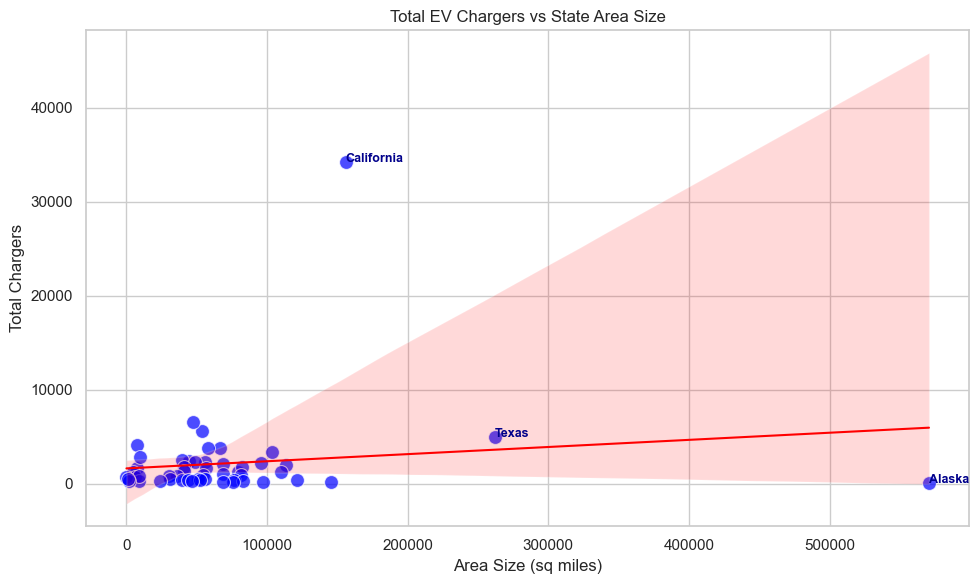

In [93]:
def charger_density(df):
    df['charger_density'] = df['total chargers'] / df['area size']
    return df

def get_outliers(df, charger_thresh=10000, area_thresh=150000):
    mask = (df['total chargers'] > charger_thresh) | (df['area size'] > area_thresh)
    return df[mask]['state'].tolist()

def plot_chargers_vs_area(data, outliers, figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    sns.set_theme(style="whitegrid")
    sns.scatterplot(
        data=data,
        x='area size',
        y='total chargers',
        s=100,
        alpha=0.7,
        color='blue',
        edgecolor='w',
        ax=ax
    )

    sns.regplot(
        data=data,
        x='area size',
        y='total chargers',
        scatter=False,
        color='red',
        line_kws={"linewidth": 1.5},
        ax=ax
    )

    for state in outliers:
        row = data[data['state'] == state]
        if not row.empty:
            x = row['area size'].values[0]
            y = row['total chargers'].values[0]
            ax.text(x, y, state, fontsize=9, color='darkblue', weight='bold')

    ax.set_title('Total EV Chargers vs State Area Size')
    ax.set_xlabel('Area Size (sq miles)')
    ax.set_ylabel('Total Chargers')
    plt.tight_layout()
    plt.show()

def print_density_summary(df):
    max_row = df.loc[df['charger_density'].idxmax()]
    min_row = df.loc[df['charger_density'].idxmin()]
    print(f"Highest density: {max_row['state']} ({max_row['charger_density']:.6f})")
    print(f"Lowest density: {min_row['state']} ({min_row['charger_density']:.6f})")

ev_charger_data = charger_density(ev_charger_data)
print_density_summary(ev_charger_data)

outlier_states = get_outliers(ev_charger_data, charger_thresh=10000, area_thresh=150000)
plot_chargers_vs_area(ev_charger_data, outliers=outlier_states)

### EV-to-Charger Ratio

- The ratio between electric vehicles and chargers offers insight into infrastructure strain.
- The **average ratio** is approximately **14.58**, and the **median** is **14.19**, showing moderate variation across states.
- **New Jersey** has the **highest ratio** at **41.33**, indicating a high number of EVs per charger and potential access challenges.
- **Wyoming** has the **lowest ratio** at **4.18**, suggesting better charger coverage per vehicle.
- The **standard deviation** is **6.59**, and the **variance** is **43.46**, reinforcing the uneven distribution of charging infrastructure.
- These figures highlight potential strain in high-ratio states, where infrastructure may lag behind EV growth.

---

### EV Charger Distribution Across Top States

- **Level 2 chargers** dominate the landscape, comprising **80.6%** of all public EV chargers.
- **DC Fast Chargers (Level 3)** account for **18.2%**, reflecting growing investment in rapid charging.
- **Level 1 chargers** are nearly obsolete, making up just **1.2%** of the total.
- A pie chart visualization reinforces this distribution, with Level 2 forming the bulk and Level 1 barely visible.

---

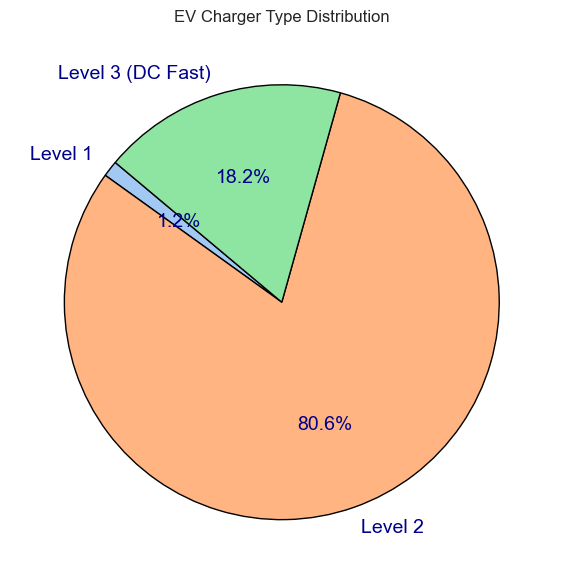

In [94]:
charger_totals = [
    ev_charger_data['level 1 chargers'].sum(),
    ev_charger_data['level 2 chargers'].sum(),
    ev_charger_data['level 3 chargers'].sum()
]

labels = ['Level 1', 'Level 2', 'Level 3 (DC Fast)']
colors = sns.color_palette('pastel')[0:3]

plt.figure(figsize=(8, 6))
plt.pie(
    charger_totals,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    textprops={'color': 'darkblue', 'fontsize': 14}
)

plt.title('EV Charger Type Distribution')
plt.tight_layout()

### EV Charger Distribution Across Top States

- **Focus**: Proportion of DC Fast Chargers (DCFC) relative to total public EV chargers in the top 10 EV states.
- **New Jersey** leads with a DCFC share **above 0.3**, significantly higher than its peers.
- **California, New York, Washington**, and others fall at or below **0.2**, indicating a stronger reliance on **Level 2 chargers**.
- This reflects a **divergence in infrastructure priorities**:
  - States with lower DCFC shares may prioritize **broad accessibility** through slower, distributed charging.
  - New Jersey may emphasize **high-speed throughput**, likely due to **dense urban areas** or **commuter-heavy corridors**.
- **Legacy infrastructure** and **early adoption timelines** may also influence the current mix, with some states still transitioning from older Level 2 networks.


C:\Users\Yoav\AppData\Local\Temp\ipykernel_17504\3056768204.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


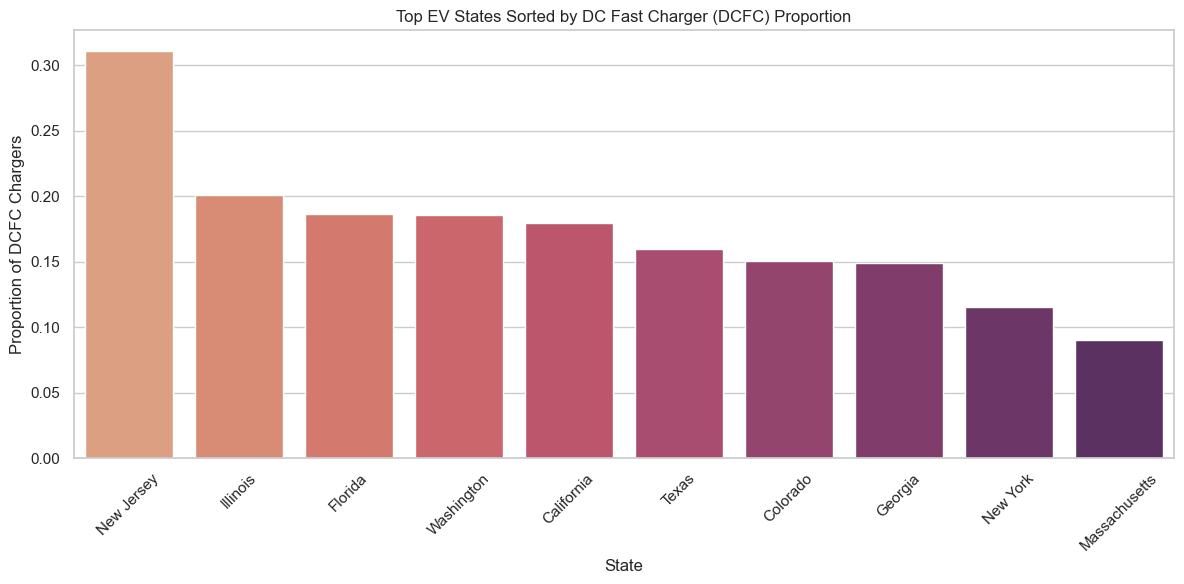

In [ ]:
# Create the ratio column for DCFC chargers
ev_charger_data['level_3_ratio'] = ev_charger_data['level 3 chargers'] / ev_charger_data['total chargers']

# Get top 10 states by EV count
top_ev_states = ev_charger_data.sort_values('total evs', ascending=False).head(10)

# Sort those top EV states by DCFC charger proportion
top_ev_states_sorted = top_ev_states.sort_values(by='level_3_ratio', ascending=False)

# Extract sorted state names for plotting order
sorted_states = top_ev_states_sorted['state'].tolist()

# Plot the sorted bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_ev_states_sorted,
    x='state',
    y='level_3_ratio',
    order=sorted_states,
    palette='flare'
)

plt.title('Top EV States Sorted by DC Fast Charger (DCFC) Proportion')
plt.xlabel('State')
plt.ylabel('Proportion of DCFC Chargers')
plt.xticks(rotation=45)
plt.tight_layout()


##  Conclusions

The data reveals a clear imbalance between EV adoption and charging infrastructure across U.S. states. While California leads in both electric vehicle ownership and charger deployment, the national landscape is marked by uneven progress. Many states fall significantly below average in charger density, and the high variability in EV counts and infrastructure availability suggests that access is far from equitable. Geographic challenges, such as large land areas and dispersed populations, make infrastructure deployment more complex, especially in rural regions. However, the presence of outliers shows that urban concentration and proactive policy can dramatically improve charger accessibility.

The EV-to-charger ratio further highlights the strain on infrastructure in certain states. New Jersey, with the highest ratio, faces a potential bottleneck in charging access, indicating that its EV growth may be outpacing infrastructure expansion. In contrast, Wyoming’s low ratio suggests a more favorable balance between vehicles and chargers. These disparities underscore the importance of strategic planning and investment to ensure that infrastructure keeps pace with rising EV adoption. Without targeted efforts, states with high ratios may experience congestion and reduced usability for EV drivers.

The distribution of charger types also reflects a transitional phase in the evolution of EV infrastructure. Level 2 chargers dominate the network due to their practicality and widespread deployment in homes, workplaces, and public spaces. Level 1 chargers, now nearly obsolete, represent legacy systems from earlier adoption phases. Meanwhile, the growing presence of DC Fast Chargers (Level 3) signals a shift toward high-speed, performance-oriented infrastructure. This trend is likely driven by increased demand for rapid charging, expansion into underserved areas, and upgrades from outdated systems, pointing to a broader modernization effort.

Among the top EV states, New Jersey stands out for its aggressive deployment of DC Fast Chargers, with a proportion exceeding 0.3—far above its peers. Other leading states, including California and New York, remain below 0.2, indicating a continued reliance on slower Level 2 chargers. This divergence may reflect differences in policy priorities, urban density, and infrastructure strategies. New Jersey’s emphasis on high-speed accessibility suggests a forward-looking approach, while other states may be expanding more gradually or upgrading legacy systems. Overall, the uneven pace of DCFC deployment highlights the broader challenge of achieving nationwide infrastructure modernization.